In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

import sys

from IPython import display

import matplotlib.pyplot as plt

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
sys.path.append("../../gated-graph-neural-network-samples")
from utils import *

In [4]:
class GNN():
    def __init__(self, h_dim = 5, edge_types = 1):
        self.params = {}
        self.placeholders = {}
        self.weights = {}
        
        self.params["hidden_size"] = h_dim
        self.params["edge_types"] = edge_types
        self.params["use_edge_bias"] = True
        self.params['num_timesteps'] = 10
    
    
    def prepare_specific_graph_model(self) -> None:
        h_dim = self.params['hidden_size']
        # inputs
        self.placeholders['graph_state_keep_prob'] = tf.placeholder(tf.float32, None, name='graph_state_keep_prob')
        self.placeholders['edge_weight_dropout_keep_prob'] = tf.placeholder(tf.float32, None, name='edge_weight_dropout_keep_prob')
        self.placeholders['initial_node_representation'] = tf.placeholder(tf.float32,
                                                                          [None, None, self.params['hidden_size']],
                                                                          name='node_features')
        #self.placeholders['node_mask'] = tf.placeholder(tf.float32, [None, None], name='node_mask')
        self.placeholders['num_vertices'] = tf.placeholder(tf.int32, ())
        self.placeholders['adjacency_matrix'] = tf.placeholder(tf.float32,
                                                               [None, self.params["edge_types"], None, None])     # [b, e, v, v]
        self.__adjacency_matrix = tf.transpose(self.placeholders['adjacency_matrix'], [1, 0, 2, 3])         # [e, b, v, v]


        # weights
        self.weights['edge_weights'] = tf.Variable(glorot_init([self.params["edge_types"], h_dim, h_dim]))
        if self.params['use_edge_bias']:
            self.weights['edge_biases'] = tf.Variable(np.zeros([self.params["edge_types"], 1, h_dim]).astype(np.float32))
        with tf.variable_scope("gru_scope"):
            cell = tf.contrib.rnn.GRUCell(h_dim)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell,
                                                 state_keep_prob=self.placeholders['graph_state_keep_prob'])
            self.weights['node_gru'] = cell
        self.weights['last_dense'] = tf.Variable(glorot_init([h_dim, 2]))
        self.weights['last_bias'] = tf.get_variable('bias', shape = [2], dtype = tf.float32)
        
    
    def compute_final_node_representations(self) -> tf.Tensor:
        v = self.placeholders['num_vertices']
        h_dim = self.params['hidden_size']
        h = self.placeholders['initial_node_representation']                                                # [b, v, h]
        h = tf.reshape(h, [-1, h_dim])

        with tf.variable_scope("gru_scope") as scope:
            for i in range(self.params['num_timesteps']):
                if i > 0:
                    tf.get_variable_scope().reuse_variables()
                for edge_type in range(self.params["edge_types"]):
                    m = tf.matmul(h, tf.nn.dropout(self.weights['edge_weights'][edge_type],
                                                   keep_prob=self.placeholders['edge_weight_dropout_keep_prob'])) # [b*v, h]
                    m = tf.reshape(m, [-1, v, h_dim])                                                       # [b, v, h]
                    if self.params['use_edge_bias']:
                        m += self.weights['edge_biases'][edge_type]                                         # [b, v, h]
                    if edge_type == 0:
                        acts = tf.matmul(self.__adjacency_matrix[edge_type], m)
                    else:
                        acts += tf.matmul(self.__adjacency_matrix[edge_type], m)
                acts = tf.reshape(acts, [-1, h_dim])                                                        # [b*v, h]

                h = self.weights['node_gru'](acts, h)[1]                                                    # [b*v, h]
            last_h = tf.reshape(h, [-1, v, h_dim])
        return last_h
            
    def predict(self, last_h):
        last_h = tf.reshape(last_h, [-1, self.params["hidden_size"]])                                       # [b*v, h]
        
        logits = tf.matmul(last_h, self.weights['last_dense']) + self.weights['last_bias']
        
        output = tf.nn.softmax(logits)
        return output, logits
    
    def loss(self, logits, target):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = target, logits=logits))
        return loss
    
    


In [5]:
keep_p = 1

In [6]:
def process_graph(sess, gnn, adj, emb, keep_p=keep_p):
    feed_dict = {
        gnn.placeholders['graph_state_keep_prob'] : keep_p,
        gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
        gnn.placeholders['initial_node_representation'] : np.expand_dims(emb[:, :], 0) ,
        #gnn.placeholders['node_mask'] : adj,
        gnn.placeholders['num_vertices'] : adj.shape[0],
        gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(adj, 0), 0),
    }
    
    return sess.run(out, feed_dict=feed_dict)
     
def process_batch(sess, gnn, embs, adjs):
    answ = []
    
    for i, (batch_e, batch_a, batch_t) in enumerate(iterate_minibatches(\
            embs, adjs, test_adjs, 1, shuffle = False)):

        batch_embs = batch_e[0][:,1:]
        batch_adj = batch_a[0][0]

        answ.append(process_graph(sess, gnn, batch_adj, batch_embs))
    return answ

In [214]:
tf.reset_default_graph()
sess = tf.Session()


gnn = GNN(4)
gnn.prepare_specific_graph_model()
last_h = gnn.compute_final_node_representations()
out, logits = gnn.predict(last_h = last_h)

target = tf.placeholder(tf.float32, [None, 2])


loss = gnn.loss(logits, target)

In [215]:
opt = tf.train.AdamOptimizer()
train_step = opt.minimize(loss)

In [216]:
sess.run(tf.global_variables_initializer())

In [198]:
#sess.run([last_h, out, logits, loss], feed_dict=feed_dict)

In [106]:
for i in range(100):
    l = sess.run([loss, train_step], feed_dict=feed_dict)

In [41]:
embs = np.load("../../data/gnn_prepared/embs.npy")
adjs = np.load("../../data/gnn_prepared/adjs.npy")
targets = np.load("../../data/gnn_prepared/target.npy")

In [43]:
embs = np.array([np.hstack((x, np.zeros((x.shape[0], 5)))) for x in embs])

In [45]:
train_embs, test_embs = embs[:800], embs[800:]
train_adjs, test_adjs = adjs[:800], adjs[800:]
train_targets, test_targets = targets[:800], targets[800:]

In [47]:
def iterate_minibatches(e,a,t, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(e.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, e.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield e[excerpt], a[excerpt], t[excerpt]

In [217]:
train_losses = []
test_losses = []

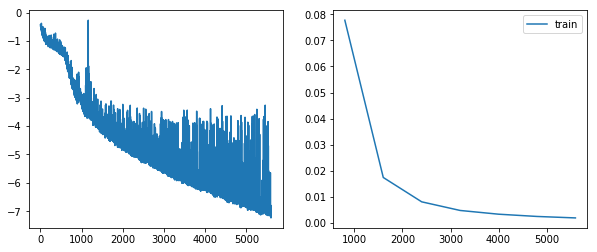

In [218]:
epochs = 7
for epoch in range(epochs):
    for i, (batch_e, batch_a, batch_t) in enumerate(iterate_minibatches(\
                train_embs, train_adjs, train_targets, 1)):

        batch_embs = batch_e[0][:,1:5]
        batch_adj = batch_a[0][0]
        batch_target = np.zeros((batch_t[0].shape[0], 2))
        batch_target[np.arange(batch_target.shape[0]), batch_t[0]] = 1
                
#         print(batch_e[0].shape, batch_adj.shape)
        
        
        feed_dict = {
            gnn.placeholders['graph_state_keep_prob'] : keep_p,
            gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
            gnn.placeholders['initial_node_representation'] : np.expand_dims(batch_embs, 0) ,
            #gnn.placeholders['node_mask'] : adj,
            gnn.placeholders['num_vertices'] : batch_adj.shape[0],
            gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(batch_adj, 0), 0),
            target : batch_target
        }
        
        batch_loss = sess.run([train_step,loss], feed_dict=feed_dict)
        
        train_losses.append(batch_loss[1])
    
    batch_loss = 0
    for i, (batch_e, batch_a, batch_t) in enumerate(iterate_minibatches(\
                test_embs, test_adjs, test_targets, 1)):

        batch_embs = batch_e[0][:,1:5]
        batch_adj = batch_a[0][0]
        batch_target = np.zeros((batch_t[0].shape[0], 2))
        batch_target[np.arange(batch_target.shape[0]), batch_t[0]] = 1

        feed_dict = {
            gnn.placeholders['graph_state_keep_prob'] : keep_p,
            gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
            gnn.placeholders['initial_node_representation'] : np.expand_dims(batch_embs, 0) ,
            #gnn.placeholders['node_mask'] : adj,
            gnn.placeholders['num_vertices'] : batch_adj.shape[0],
            gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(batch_adj, 0), 0),
            target : batch_target
        }
        
        curr_loss = sess.run(loss, feed_dict=feed_dict) / test_adjs.shape[0]
        batch_loss += curr_loss
        
    test_losses.append(batch_loss)
        
        
    if epoch%1==0:
        display.clear_output()
        f = plt.figure(figsize= (10, 4))
        ax1, ax2 = f.subplots(1,2)
        ax1.plot(np.log(train_losses), label='train')
        ax2.plot([i * train_adjs.shape[0] for i in range(1, len(test_losses) + 1)], test_losses, label='train')
        plt.legend()
        plt.show()
#         curr_loss += batch_loss[1]

#         if i % n == 0:
#             if i != 0:
#                 losses_each_n.append( curr_loss / n)
            
#             curr_loss = 0


#             display.clear_output(wait=True)
#             plt.plot(losses_each_n[1:], label='train')
#             plt.plot(val_x, val_losses, label='test')
#             plt.legend()
#             plt.show()
            
#     val_loss = sess.run(loss,  feed_dict={inp : np.hstack((X, X_emb[:,:5]))[800:].reshape(-1, 150), target: y[800:].reshape(-1, 100)})
#     val_losses.append(val_loss)
#     val_x.append(len(losses_each_n))
    
#     curr_loss == 0

        #print(batch_loss[1])

In [219]:
test_losses

[0.0777127224393189,
 0.01748372836969794,
 0.008156977645121518,
 0.00485250554862432,
 0.0034218176733702426,
 0.0025579601892968635,
 0.001996580460981931]

In [221]:
targets = []
outs = []

for i, (batch_e, batch_a, batch_t) in enumerate(iterate_minibatches(\
                test_embs, test_adjs, test_targets, 1)):

        batch_embs = batch_e[0][:,1:5]
        batch_adj = batch_a[0][0]
        batch_target = np.zeros((batch_t[0].shape[0], 2))
        batch_target[np.arange(batch_target.shape[0]), batch_t[0]] = 1

        feed_dict = {
            gnn.placeholders['graph_state_keep_prob'] : keep_p,
            gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
            gnn.placeholders['initial_node_representation'] : np.expand_dims(batch_embs, 0) ,
            #gnn.placeholders['node_mask'] : adj,
            gnn.placeholders['num_vertices'] : batch_adj.shape[0],
            gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(batch_adj, 0), 0),
            target : batch_target
        }
        
        outs.append(sess.run(out, feed_dict=feed_dict))
        targets.append(batch_t)
       

In [203]:
from sklearn.metrics import roc_auc_score

In [222]:
roc_auc_score(np.hstack([x[0] for x in targets]), np.vstack(outs)[:, 1])

0.9999974347723305

In [66]:
path = "../../data/gnn_prepared/"
name = "ES3_22"
emb_ES3 = np.load(path + name + "_emb.npy")
adj_ES3 = np.load(path + name + "_adj.npy")
#targets = np.load("../../data/gnn_prepared/target.npy"

In [70]:
pred_ES3 = process_graph(sess, gnn, adj_ES3, np.hstack((emb_ES3[:,:], np.ones((emb_ES3.shape[0], 5)))))

In [88]:
import os
import pickle

In [89]:
es_answ_list = pickle.load(open("../../data/answers/ES_answers_50", 'rb'))

In [90]:
def lists_to_gr(lists, n):
    gr = np.zeros((n,n))
    for arr in lists:
        for a,b in zip(arr, arr[1:]):
            gr[a, b] = 1
            
    return gr

In [91]:
path = "../../data/graphs/ES/"
files = sorted(os.listdir(path))

In [92]:
files

['1.npy', '2.npy', '3.npy', '4.npy']

In [93]:
ES_x = []
for f in files:
    ES_x.append(np.load(path + f)[:36, :36])


In [96]:
ES_x = [ES_x[0][:19,:19], ES_x[1][:19,:19],ES_x[2][:36,:36],ES_x[3][:36,:36],]

In [97]:
ES_y = [lists_to_gr(es_answ_list[i], ES_x[i].shape[0]) for i in range(4)]

In [208]:
es_embs = []
es_targets = []
es_adjs = []
es_p = []

for x, y in zip(ES_x, ES_y):
    adj, emb, t, p = gu.process_graph(x, y)
    
    es_embs.append(np.hstack((emb, np.zeros_like(emb))))
    es_adjs.append(adj)
    es_targets.append(t)
    es_p.append(sorted(p.keys()))
    
es_embs = np.array(es_embs)
es_targets = np.array(es_targets)
es_adjs = np.array(es_adjs)

In [106]:
es_embs_all = np.vstack(es_embs)
es_targets_all = np.hstack(es_targets)

In [115]:
es_adjs[1].shape

(317, 317)

In [223]:
targets = []
outs = []

for i, (batch_e, batch_a, batch_t) in enumerate(iterate_minibatches(\
                    es_embs, es_adjs, es_targets, 1, 0)):

        batch_embs = batch_e[0][:,1:5]
        batch_adj = batch_a[0]
        batch_target = np.zeros((batch_t[0].shape[0], 2))
        batch_target[np.arange(batch_target.shape[0]), batch_t[0]] = 1

        feed_dict = {
            gnn.placeholders['graph_state_keep_prob'] : keep_p,
            gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
            gnn.placeholders['initial_node_representation'] : np.expand_dims(batch_embs, 0) ,
            #gnn.placeholders['node_mask'] : adj,
            gnn.placeholders['num_vertices'] : batch_adj.shape[0],
            gnn.placeholders['adjacency_matrix'] : np.expand_dims(np.expand_dims(batch_adj, 0), 0),
            target : batch_target
        }
        
        outs.append(sess.run(out, feed_dict=feed_dict))
        targets.append(batch_t)
       

In [224]:
roc_auc_score(np.hstack([x[0] for x in targets]), np.vstack(outs)[:, 1])

0.9688059434300036

In [71]:
sys.path.append("../utils")

In [72]:
import graph_transformation as gu
import plot_utils as pu

In [232]:
def p_to_g(pairs, pred):
    gr = np.zeros((36,36))
    for p in np.array(pairs)[pred > 0.5]:
        
        gr[p[0], p[1]] = 1
    return gr

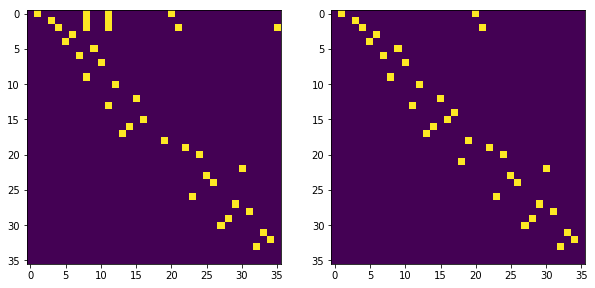

In [233]:
pu.plot_grs(p_to_g(es_p[2], outs[2][:, 1]),p_to_g(es_p[2], targets[2][0]))

In [231]:
targets[2][0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [128]:
outs[2].shape

(527, 2)

In [60]:
np.save("../../data/gnn_prepared/answ_ES4", pred_ES3)

In [63]:
answ = process_batch(sess, gnn, test_embs, test_adjs)

In [54]:
np.hstack([x[:, 1] for x in answ]).shape

(49197,)

In [64]:
roc_auc_score(np.hstack(test_targets), np.hstack([x[:, 1] for x in answ]))

0.9999992932111769

In [56]:
from sklearn.metrics import roc_auc_score, f1_score

In [102]:
feed_dict = {
    gnn.placeholders['graph_state_keep_prob'] : keep_p,
    gnn.placeholders['edge_weight_dropout_keep_prob'] : keep_p,
    gnn.placeholders['initial_node_representation'] : initial_nodes_representations,
    #gnn.placeholders['node_mask'] : adj,
    gnn.placeholders['num_vertices'] : n_v,
    gnn.placeholders['adjacency_matrix'] : adj,
    
    target : np.array([[0, 1], [0, 1]])
}